In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import files
uploaded = files.upload()

Saving VMD.xlsx to VMD.xlsx


In [3]:
df_2 = pd.read_excel("VMD.xlsx")

In [4]:
df_2

,T©,P(kPa),concentration(M),Flow Rate(L/h),flux(l/m^2h)
0,319.2,5.1,1.0,50,13.5
1,319.2,5.1,1.1,50,13.4
2,319.2,5.1,1.2,50,13.2
3,319.2,5.1,1.3,50,13.2
4,319.2,5.1,1.4,50,13.1
...,...,...,...,...,...
109,310.2,4.0,2.4,100,8.3
110,310.2,4.0,2.5,100,8.1
111,310.2,4.0,2.7,100,8.0
112,310.2,4.0,2.8,100,7.9


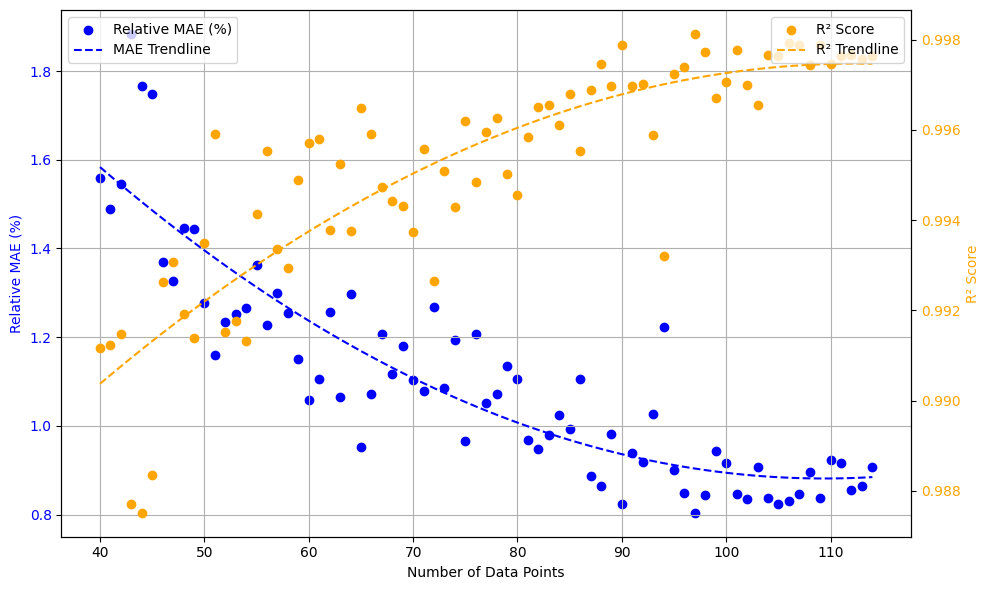

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from google.colab import files

# Prepare lists to store Relative MAE and R² for each subset size
relative_mae_list = []
r2_list = []

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Using 5-fold cross-validation

# Loop through different subset sizes (from 40 to 114 for df_2)
for n_data_points in range(40, 115):  # Adjust the range for df_2
    # Randomly sample n_data_points from df_2 with a fixed random seed
    df_sample = df_2.sample(n=n_data_points, random_state=42)

    # Split data into features (X) and target (y)
    X = df_sample.iloc[:, :-1].to_numpy()  # All columns except the last one
    y = df_sample.iloc[:, -1].to_numpy()   # Last column is the target value

    # Normalizing features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Prepare lists to store metrics for each fold
    fold_mae_list = []
    fold_r2_list = []

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X_scaled):
        # Split into training and testing based on the fold
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Define the XGBoost model
        xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

        # Hyperparameter tuning using GridSearchCV
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'colsample_bytree': [0.7, 0.8, 0.9],
        }

        # Create GridSearchCV with cross-validation (no random_state argument here)
        grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Identify the best model from GridSearchCV
        best_model = grid_search.best_estimator_

        # Make predictions
        y_test_pred = best_model.predict(X_test)

        # Calculate MAE for the test dataset
        mae_test = mean_absolute_error(y_test, y_test_pred)

        # Calculate Relative MAE (relative to the mean of the actual values)
        relative_mae = (mae_test / np.mean(y_test)) * 100  # Convert to percentage
        fold_mae_list.append(relative_mae)

        # Calculate R² score for the test dataset
        r2_test = r2_score(y_test, y_test_pred)
        fold_r2_list.append(r2_test)

    # Average the metrics across the folds
    avg_relative_mae = np.mean(fold_mae_list)
    avg_r2 = np.mean(fold_r2_list)

    # Store the results for this subset size
    relative_mae_list.append((n_data_points, avg_relative_mae))
    r2_list.append((n_data_points, avg_r2))

# Convert the lists into NumPy arrays for easy regression
relative_mae_array = np.array(relative_mae_list)
r2_array = np.array(r2_list)

# Fit a polynomial regression line (degree=2) for Relative MAE
poly_features = PolynomialFeatures(degree=2)
X_poly_mae = poly_features.fit_transform(relative_mae_array[:, 0].reshape(-1, 1))
mae_model = LinearRegression()
mae_model.fit(X_poly_mae, relative_mae_array[:, 1])
mae_trend = mae_model.predict(X_poly_mae)

# Fit a polynomial regression line (degree=2) for R²
X_poly_r2 = poly_features.fit_transform(r2_array[:, 0].reshape(-1, 1))
r2_model = LinearRegression()
r2_model.fit(X_poly_r2, r2_array[:, 1])
r2_trend = r2_model.predict(X_poly_r2)

# Plot Relative MAE and R² with regression lines
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Relative MAE
ax1.scatter(relative_mae_array[:, 0], relative_mae_array[:, 1], color='blue', label='Relative MAE (%)')
ax1.plot(relative_mae_array[:, 0], mae_trend, color='blue', linestyle='--', label='MAE Trendline')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Relative MAE (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a second y-axis for R²
ax2 = ax1.twinx()
ax2.scatter(r2_array[:, 0], r2_array[:, 1], color='orange', label='R² Score')
ax2.plot(r2_array[:, 0], r2_trend, color='orange', linestyle='--', label='R² Trendline')
ax2.set_ylabel('R² Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legend

fig.tight_layout()

# Add legends for both metrics
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the plot as a TIFF file
plt.savefig('/content/relative_mae_r2_plot.vmd.tiff', format='tiff')

# Show the plot
plt.show()

# Optionally, download the saved TIFF file
files.download('/content/relative_mae_r2_plot.vmd.tiff')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from google.colab import files
uploaded = files.upload()

Saving DCMD.xlsx to DCMD.xlsx


In [6]:
df_1 = pd.read_excel("DCMD.xlsx")

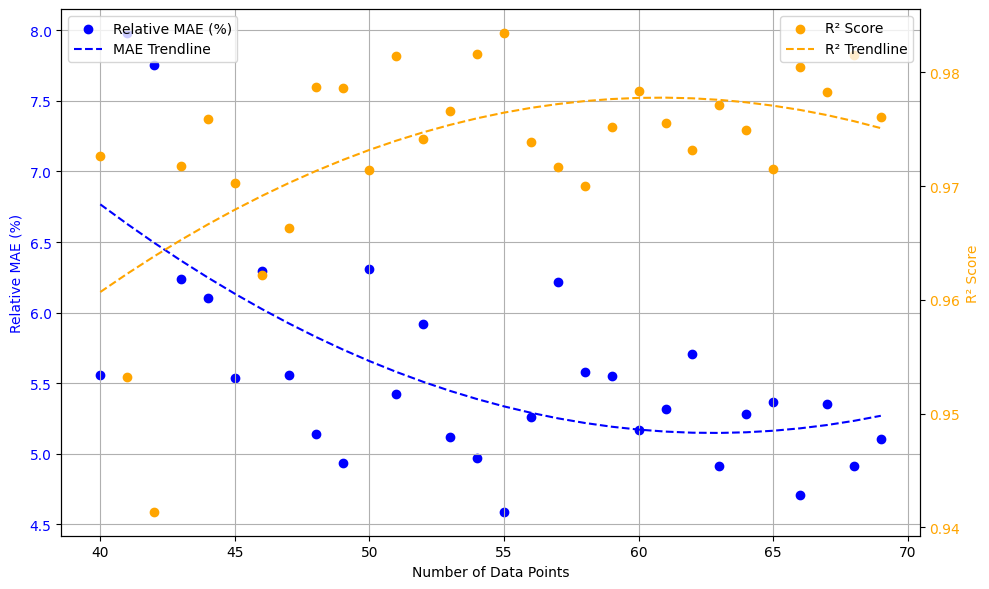

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from google.colab import files

# Prepare lists to store Relative MAE and R² for each subset size
relative_mae_list = []
r2_list = []

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Using 5-fold cross-validation

# Loop through different subset sizes (from 40 to 69 for df_1)
for n_data_points in range(40, 70):  # Adjust the range for df_1
    # Randomly sample n_data_points from df_1 with a fixed random seed
    df_sample = df_1.sample(n=n_data_points, random_state=42)

    # Split data into features (X) and target (y)
    X = df_sample.iloc[:, :-1].to_numpy()  # All columns except the last one
    y = df_sample.iloc[:, -1].to_numpy()   # Last column is the target value

    # Normalizing features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Prepare lists to store metrics for each fold
    fold_mae_list = []
    fold_r2_list = []

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X_scaled):
        # Split into training and testing based on the fold
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Define the XGBoost model
        xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

        # Hyperparameter tuning using GridSearchCV
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'colsample_bytree': [0.7, 0.8, 0.9],
        }

        # Create GridSearchCV with cross-validation (no random_state argument here)
        grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Identify the best model from GridSearchCV
        best_model = grid_search.best_estimator_

        # Make predictions
        y_test_pred = best_model.predict(X_test)

        # Calculate MAE for the test dataset
        mae_test = mean_absolute_error(y_test, y_test_pred)

        # Calculate Relative MAE (relative to the mean of the actual values)
        relative_mae = (mae_test / np.mean(y_test)) * 100  # Convert to percentage
        fold_mae_list.append(relative_mae)

        # Calculate R² score for the test dataset
        r2_test = r2_score(y_test, y_test_pred)
        fold_r2_list.append(r2_test)

    # Average the metrics across the folds
    avg_relative_mae = np.mean(fold_mae_list)
    avg_r2 = np.mean(fold_r2_list)

    # Store the results for this subset size
    relative_mae_list.append((n_data_points, avg_relative_mae))
    r2_list.append((n_data_points, avg_r2))

# Convert the lists into NumPy arrays for easy regression
relative_mae_array = np.array(relative_mae_list)
r2_array = np.array(r2_list)

# Fit a polynomial regression line (degree=2) for Relative MAE
poly_features = PolynomialFeatures(degree=2)
X_poly_mae = poly_features.fit_transform(relative_mae_array[:, 0].reshape(-1, 1))
mae_model = LinearRegression()
mae_model.fit(X_poly_mae, relative_mae_array[:, 1])
mae_trend = mae_model.predict(X_poly_mae)

# Fit a polynomial regression line (degree=2) for R²
X_poly_r2 = poly_features.fit_transform(r2_array[:, 0].reshape(-1, 1))
r2_model = LinearRegression()
r2_model.fit(X_poly_r2, r2_array[:, 1])
r2_trend = r2_model.predict(X_poly_r2)

# Plot Relative MAE and R² with regression lines
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Relative MAE
ax1.scatter(relative_mae_array[:, 0], relative_mae_array[:, 1], color='blue', label='Relative MAE (%)')
ax1.plot(relative_mae_array[:, 0], mae_trend, color='blue', linestyle='--', label='MAE Trendline')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Relative MAE (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a second y-axis for R²
ax2 = ax1.twinx()
ax2.scatter(r2_array[:, 0], r2_array[:, 1], color='orange', label='R² Score')
ax2.plot(r2_array[:, 0], r2_trend, color='orange', linestyle='--', label='R² Trendline')
ax2.set_ylabel('R² Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legend

fig.tight_layout()

# Add legends for both metrics
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the plot as a TIFF file
plt.savefig('/content/relative_mae_r2_plot.dcmd.tiff', format='tiff')

# Show the plot
plt.show()

# Optionally, download the saved TIFF file
files.download('/content/relative_mae_r2_plot.dcmd.tiff')


In [7]:
from google.colab import files
uploaded = files.upload()

Saving AGMD.xlsx to AGMD.xlsx


In [8]:
df_3 = pd.read_excel("AGMD.xlsx")

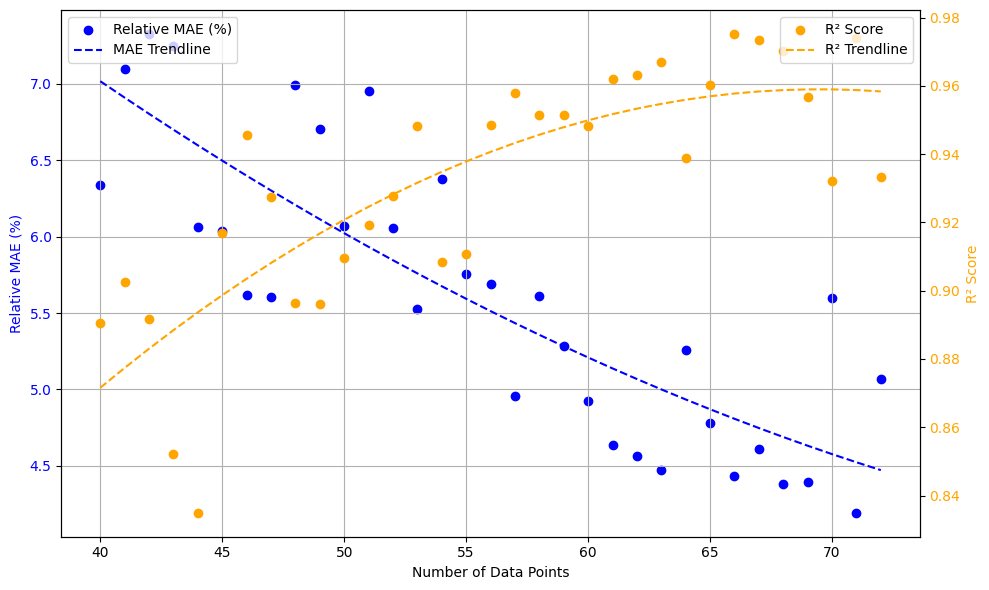

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from google.colab import files

# Prepare lists to store Relative MAE and R² for each subset size
relative_mae_list = []
r2_list = []

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Using 5-fold cross-validation

# Loop through different subset sizes (from 40 to 72 for df_3)
for n_data_points in range(40, 73):  # Adjust the range for df_3
    # Randomly sample n_data_points from df_3 with a fixed random seed
    df_sample = df_3.sample(n=n_data_points, random_state=42)

    # Split data into features (X) and target (y)
    X = df_sample.iloc[:, :-1].to_numpy()  # All columns except the last one
    y = df_sample.iloc[:, -1].to_numpy()   # Last column is the target value

    # Normalizing features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Prepare lists to store metrics for each fold
    fold_mae_list = []
    fold_r2_list = []

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X_scaled):
        # Split into training and testing based on the fold
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Define the XGBoost model
        xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

        # Hyperparameter tuning using GridSearchCV
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'colsample_bytree': [0.7, 0.8, 0.9],
        }

        # Create GridSearchCV with cross-validation (no random_state argument here)
        grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Identify the best model from GridSearchCV
        best_model = grid_search.best_estimator_

        # Make predictions
        y_test_pred = best_model.predict(X_test)

        # Calculate MAE for the test dataset
        mae_test = mean_absolute_error(y_test, y_test_pred)

        # Calculate Relative MAE (relative to the mean of the actual values)
        relative_mae = (mae_test / np.mean(y_test)) * 100  # Convert to percentage
        fold_mae_list.append(relative_mae)

        # Calculate R² score for the test dataset
        r2_test = r2_score(y_test, y_test_pred)
        fold_r2_list.append(r2_test)

    # Average the metrics across the folds
    avg_relative_mae = np.mean(fold_mae_list)
    avg_r2 = np.mean(fold_r2_list)

    # Store the results for this subset size
    relative_mae_list.append((n_data_points, avg_relative_mae))
    r2_list.append((n_data_points, avg_r2))

# Convert the lists into NumPy arrays for easy regression
relative_mae_array = np.array(relative_mae_list)
r2_array = np.array(r2_list)

# Fit a polynomial regression line (degree=2) for Relative MAE
poly_features = PolynomialFeatures(degree=2)
X_poly_mae = poly_features.fit_transform(relative_mae_array[:, 0].reshape(-1, 1))
mae_model = LinearRegression()
mae_model.fit(X_poly_mae, relative_mae_array[:, 1])
mae_trend = mae_model.predict(X_poly_mae)

# Fit a polynomial regression line (degree=2) for R²
X_poly_r2 = poly_features.fit_transform(r2_array[:, 0].reshape(-1, 1))
r2_model = LinearRegression()
r2_model.fit(X_poly_r2, r2_array[:, 1])
r2_trend = r2_model.predict(X_poly_r2)

# Plot Relative MAE and R² with regression lines
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Relative MAE
ax1.scatter(relative_mae_array[:, 0], relative_mae_array[:, 1], color='blue', label='Relative MAE (%)')
ax1.plot(relative_mae_array[:, 0], mae_trend, color='blue', linestyle='--', label='MAE Trendline')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Relative MAE (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a second y-axis for R²
ax2 = ax1.twinx()
ax2.scatter(r2_array[:, 0], r2_array[:, 1], color='orange', label='R² Score')
ax2.plot(r2_array[:, 0], r2_trend, color='orange', linestyle='--', label='R² Trendline')
ax2.set_ylabel('R² Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legend

fig.tight_layout()

# Add legends for both metrics
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the plot as a TIFF file
plt.savefig('/content/relative_mae_r2_plot.agmd.tiff', format='tiff')

# Show the plot
plt.show()

# Optionally, download the saved TIFF file
files.download('/content/relative_mae_r2_plot.agmd.tiff')
